In [1]:
from IPython.core.interactiveshell import InteractiveShell
from datetime import datetime

#basic externals
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import swifter
import feather
from random import randint
from scipy import stats
import io

#visual libs
import matplotlib.pyplot  as plt
import seaborn as sns
import cv2

# sklearn model imports
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.externals import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#local imports
from xm_functions import *

InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_rows = 20
pd.options.display.max_columns = 50 
pd.set_option(
    "display.float_format", lambda x: "%.3f" % x
    )  # display numbers as decimals instead of scientific value

plt.rcParams["font.size"] = (18)

In [2]:
df = pd.read_feather('df_transformed1.feather')
df.shape
df.head(1)

C:\Users\Maly-Fenix\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


(20580, 15)

id                                           image  \
0  n02085620_10074  Images/n02085620-Chihuahua/n02085620_10074.jpg   

                                       annotation  breed breed_label  \
0  Annotation/n02085620-Chihuahua/n02085620_10074      1   Chihuahua   

          pose  width  height  box_xmin  box_ymin  box_xmax  box_ymax  \
0  Unspecified    333     500        25        10       276       498   

                             scene_img                               crop_img  \
0  Scene/Chihuahua/n02085620_10074.png  Cropped/Chihuahua/n02085620_10074.jpg   

                             masked_img  
0  Masked/Chihuahua/n02085620_10074.png

### Trying out SIFT

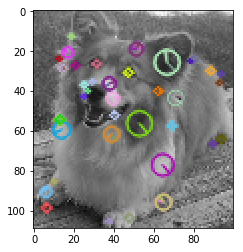

50 descriptors found


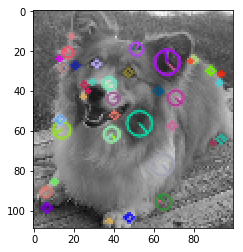

50 descriptors found


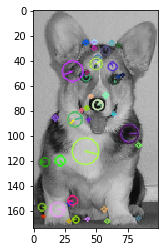

50 descriptors found


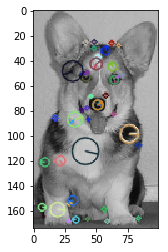

50 descriptors found


In [3]:
sift = cv2.xfeatures2d.SIFT_create(
    nOctaveLayers = 3,
    edgeThreshold = 10,
    sigma = 1.6
)
def sift_descriptors(x, display =False, resize = 100, max_features = 50, flatten=False):
    img = cv2.imread(x['crop_img'], cv2.IMREAD_UNCHANGED) #IMREAD_UNCHANGED to keep 4th channel with transparency
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img = less_colors(img)
    
    img_width =gray.shape[1]
    if img_width> resize:
        resize_ratio = resize/img_width
        gray = cv2.resize(gray,None,fx=resize_ratio, fy=resize_ratio)
        
    
    kp = sift.detect(gray,None)
    kp = sorted(kp, key=lambda x: -x.response)[:max_features]
    kp, descr = sift.compute(gray,kp)
    if display:
        img=cv2.drawKeypoints(gray,kp, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        imshow(img)
        print(descr.shape[0], 'descriptors found')
        
    if flatten: # does not work as expected
        descr= descr.flatten()
        needed_size = (max_features * 64)
        if descr.size < needed_size:
            descr = np.concatenate([descr, np.zeros(needed_size - descr.size)])
    return descr.astype(int)

df_sample=df[df.id=='n02113023_12248']
silent = df_sample.apply(lambda x: sift_descriptors(x, display =True),axis=1)
df_sample=df[df.id=='n02113023_2992']
silent = df_sample.apply(lambda x: sift_descriptors(x, display =True),axis=1)


## Visual FLANN Based matches with SIFT and SURF

Fast Library for Approximate Nearest Neighbors

SIFT


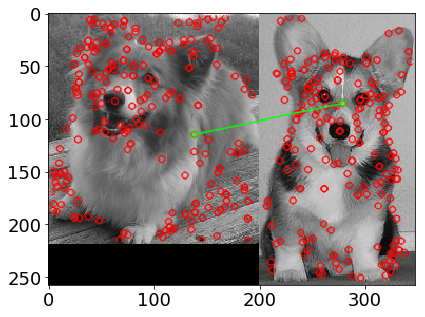

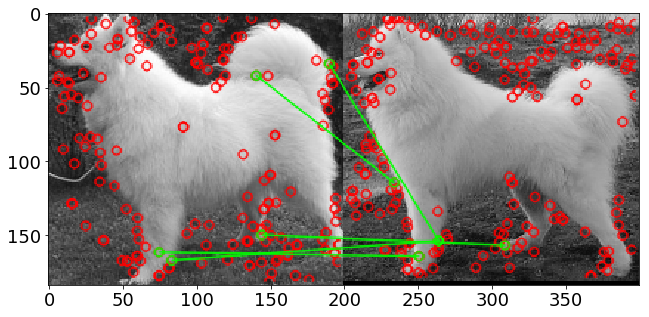

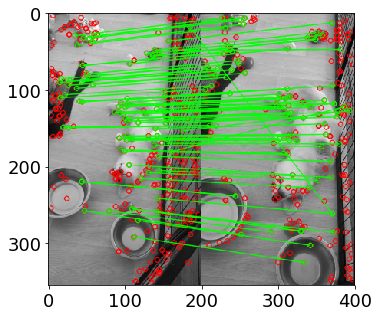

SURF


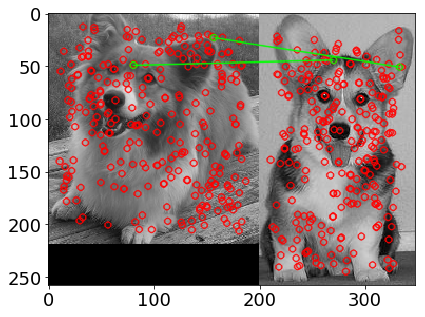

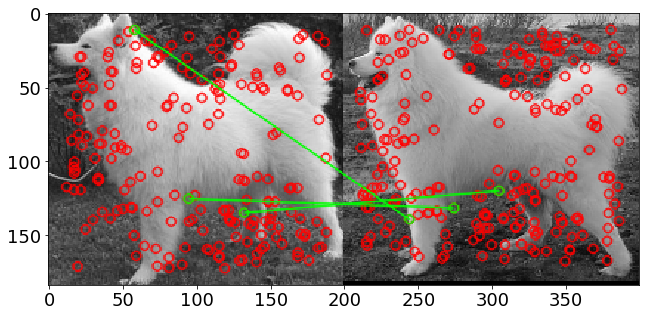

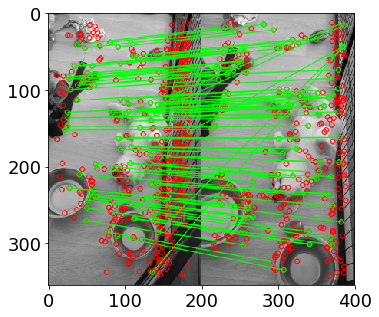

In [4]:
sift = cv2.xfeatures2d.SIFT_create(
    nOctaveLayers = 3,
    edgeThreshold = 10,
    sigma = 1.6)
surf = cv2.xfeatures2d.SURF_create(
    hessianThreshold = 100,
    nOctaves = 4,
    nOctaveLayers = 3
)

def resize_img(img, max_width):
    img_width =img.shape[1]
    if img_width> max_width:
        resize_ratio = max_width/img_width
        img = cv2.resize(img,None,fx=resize_ratio, fy=resize_ratio)
    return img

def FLANN_match(x1, x2, detection=sift, max_width = 200):
    img1 = cv2.imread(x1['crop_img'].values[0],0) # queryImage
    img2 = cv2.imread(x2['crop_img'].values[0],0) # trainImage

    img1 = resize_img(img1, max_width)
    img2 = resize_img(img2, max_width)
        
    fig_size(4,4)

    # find the keypoints and descriptors with SIFT
    kp1, des1 = detection.detectAndCompute(img1,None)
    kp2, des2 = detection.detectAndCompute(img2,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees =10)
    search_params = dict(checks=200)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            matchesMask[i]=[1,0]

    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = 0)

    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
    fig_size(15,5)
    plt.imshow(img3,),plt.show()

print('SIFT')
df_sample=df[df.id=='n02113023_12248']
df_sample2=df[df.id=='n02113023_2992']
silent = FLANN_match(df_sample,df_sample2)

df_sample=df[df.id=='n02111889_16676']
df_sample2=df[df.id=='n02111889_1363']
silent = FLANN_match(df_sample,df_sample2)

df_sample=pd.DataFrame(['Ossia/dodo1.jpg'],columns = ['crop_img'] ) 
df_sample2=pd.DataFrame(['Ossia/dodo2.jpg'],columns = ['crop_img'] ) 
silent = FLANN_match(df_sample,df_sample2) 

print('SURF')
df_sample=df[df.id=='n02113023_12248']
df_sample2=df[df.id=='n02113023_2992']
silent = FLANN_match(df_sample,df_sample2, surf)

df_sample=df[df.id=='n02111889_16676']
df_sample2=df[df.id=='n02111889_1363']
silent = FLANN_match(df_sample,df_sample2, surf)

df_sample=pd.DataFrame(['Ossia/dodo1.jpg'],columns = ['crop_img'] ) 
df_sample2=pd.DataFrame(['Ossia/dodo2.jpg'],columns = ['crop_img'] ) 
silent = FLANN_match(df_sample,df_sample2, surf)


## Testing SIFT classification on a reduced set

In [5]:
reduced_set = ['Newfoundland','giant_schnauzer', 'Maltese_dog', 'pembroke', 'Siberian_husky', 'Eskimo_dog','redbone', 'Chihuahua', 'African_hunting_dog', 'golden_retriever', 'cocker_spaniel', 'Samoyed']
mask = df['breed_label'].isin(reduced_set)
df_reduced = df.loc[mask]
df_reduced.shape

(1942, 15)

#### Get max 50 sift descriptors (128 dim) per image

In [6]:
df_results=df_reduced[['crop_img']].swifter.apply(lambda x: sift_descriptors(x),axis=1)

Pandas Apply: 100%|███████████████████████████████████████████████████████████████| 1942/1942 [00:11<00:00, 172.71it/s]


In [7]:
df_descr = pd.DataFrame(columns=['id', 'breed']+list(range(128)))
for i in range(df_reduced.shape[0]):
    descr =df_reduced[['crop_img']].iloc[[i]].apply(lambda x: sift_descriptors(x),axis=1).values
    dog_descr =  pd.DataFrame([item for sublist in descr for item in sublist])
    dog_descr['id'] = df_reduced['id'].iloc[i]
    dog_descr['breed'] = df_reduced['breed_label'].iloc[i]
    df_descr = df_descr.append(dog_descr, sort=False)

df_descr.shape
df_descr.sample(5)

(93897, 130)

id           breed   0    1   2   3  4   5   6   7    8    9  \
45   n02110185_5716  Siberian_husky   0    1   2   5  4  13  53  10   28    4   
15  n02085936_14432     Maltese_dog   3  153  68   0  0   3   1   0   11  147   
46   n02109961_5772      Eskimo_dog   0    0  43  40  0   0   0   0    3   20   
9    n02085936_2422     Maltese_dog   1    1   0   0  0   0   0   0   36    3   
36   n02085936_6424     Maltese_dog  83    8   0   0  0   0   0  27  125    8   

     10  11 12  13  14  15   16  17  18   19   20  21   22  ... 103  104 105  \
45    2   2  4   9  95  50  162   6   0    0    0   1   18  ...  26   39   0   
15   30   0  4  50  59  10   30  42   9    1    1  15  105  ...   0  152  29   
46  134  98  0   0   0   0  103  86  60    7    0   0    0  ...  14  122  25   
9     0   0  0   0   0  11  142   0   0    0    0   0    0  ...  52   24   5   
36    0   3  3   0   0  39   36   1   1  125  125  15    1  ...  22   74   5   

   106 107 108 109  110  111  112  113 114 115  116 117 118  119 120 121 122  \
45   0   0   7  29  137   68  162    5   2   1    0   0  22  103  41   7   9   
15   0   0   0   0    0    8  153    2   0   0    0   0   0   29  38   4   0   
46  14   0   0   0    6  134  116    1   0   0    0   4  10  134   5   0   0   
9    0   0   0   2   44   51  166  127   0   0    0   1  23   29  55  91  13   
36   1  15  26   5    2   39    8   18  17  70  116  12   1    6   4  29  37   

   123 124 125 126 127  
45  65   7   0   0   3  
15   0   0   3   1   4  
46   0   4  25  11   7  
9    3   1   0   0   7  
36  12   5   5   2   0  

[5 rows x 130 columns]

## Adding PCA

(93897, 128)

(93897, 32)

0.797 variance preserved with 32 features


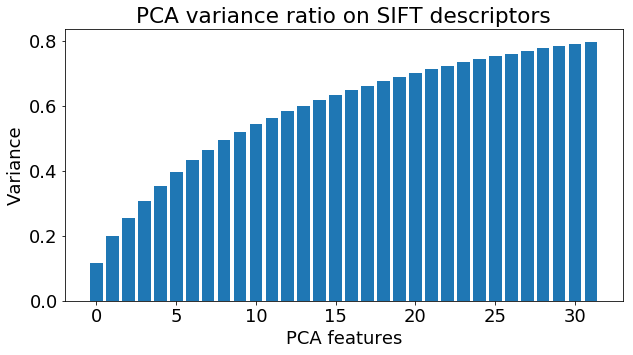

In [8]:
X=df_descr.iloc[:, 2:130]
X.shape

from sklearn.decomposition import PCA
n_components=32
pca = PCA(n_components)
X_pca = pca.fit_transform(X)
X_pca.shape
pca_var_ratios = pca.explained_variance_ratio_

print(round(max(np.cumsum(pca_var_ratios)), 3), 'variance preserved with', n_components,'features')
silent = plt.rcParams["figure.figsize"] = (10,5)
silent = plt.bar(list(range(n_components)), np.cumsum(pca_var_ratios))
legend(plt, 'PCA variance ratio on SIFT descriptors', 'PCA features', 'Variance')


#### Use Kmeans to cluster sift descriptors together

In [9]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 40)
clusters = km.fit_predict(X_pca)


In [10]:
len(clusters)
df_kmeans = df_descr[['id', 'breed']].copy()
df_kmeans['cluster'] =clusters
df_kmeans.head(3)

93897

id      breed  cluster
0  n02085620_10074  Chihuahua       31
1  n02085620_10074  Chihuahua       37
2  n02085620_10074  Chihuahua       29

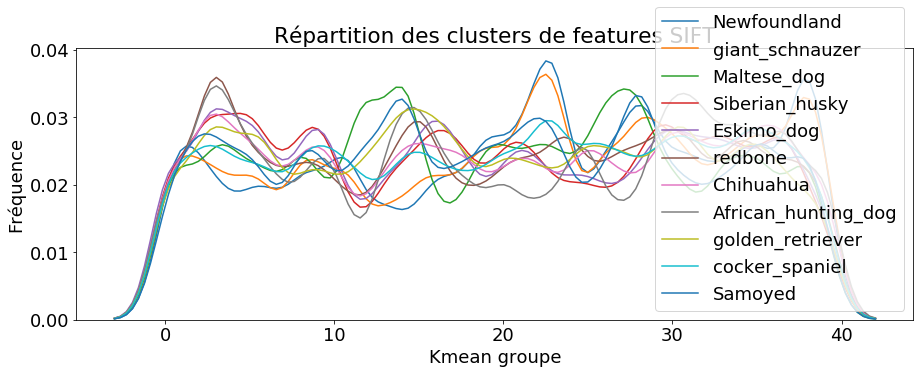

In [17]:
fig_size(15,5)
for breed in reduced_set:
    myplt = sns.kdeplot(df_kmeans['cluster'][df_kmeans.breed==breed].values, label = breed, bw=1)

legend(myplt, 'Répartition des clusters de features SIFT', 'Kmean groupe', 'Fréquence');

## TRain & test split

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
df_agg = df_kmeans.groupby('id').aggregate(lambda x: list(x))
df_agg['breed']= df_kmeans.groupby('id').agg({'breed': 'first'})
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_agg['cluster'].astype(str))
X.shape
X=pd.DataFrame(X.toarray(), index = df_agg.index)

y=df_agg['breed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42, stratify=y )

(1942, 30)

## Display distribution as 2D plot

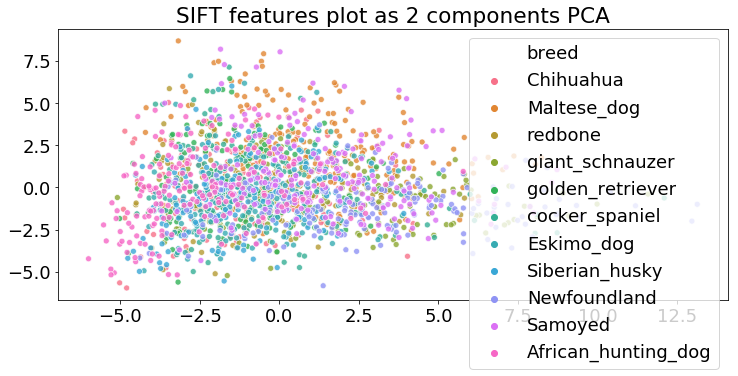

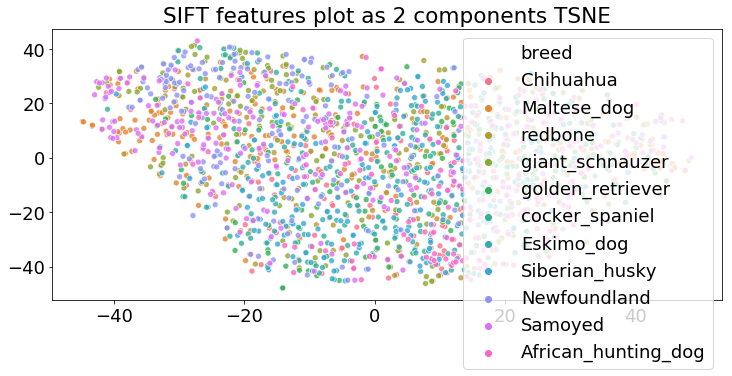

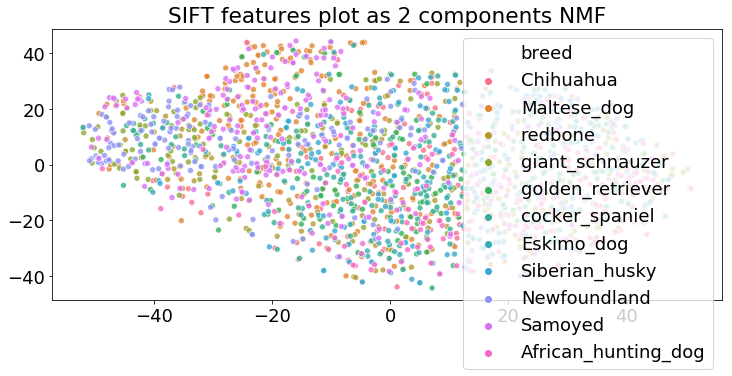

In [19]:
pca =PCA(n_components = 2)
pca_plot = pca.fit_transform(X)
y_ints = pd.factorize(y)[0]
fig_size(12,5)
sns.scatterplot(pca_plot[:,0], pca_plot[:,1], hue=y, alpha=0.8, legend='full')
legend(plt,'SIFT features plot as 2 components PCA')
plt.show()

from sklearn.manifold import TSNE
model =TSNE(n_components = 2)
model_plot = model.fit_transform(X)
y_ints = pd.factorize(y)[0]
fig_size(12,5)
sns.scatterplot(model_plot[:,0], model_plot[:,1], hue=y, alpha=0.8, legend='full')
legend(plt,'SIFT features plot as 2 components TSNE')
plt.show()

from sklearn.decomposition import NMF 
nmf =NMF(n_components = 2)
model_plot = model.fit_transform(X)
y_ints = pd.factorize(y)[0]
fig_size(12,5)
sns.scatterplot(model_plot[:,0], model_plot[:,1], hue=y, alpha=0.8, legend='full')
legend(plt,'SIFT features plot as 2 components NMF')
plt.show()

# Predictions

In [14]:
from sklearn.svm import LinearSVC
clf = LinearSVC(max_iter = 5000)
silent = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Score of :',clf.score(X_test, y_test))
print('Note : Inferior to random forests')

C:\Users\Maly-Fenix\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Score of : 0.26337448559670784
Note : Inferior to random forests


Highest score is 0.24769187144802687 Hyperparam  n_estimators : 41
41
Highest score is 0.2605599779051488 Hyperparam  n_estimators : 42
42
Highest score is 0.25538417914033457 Hyperparam  n_estimators : 38
38


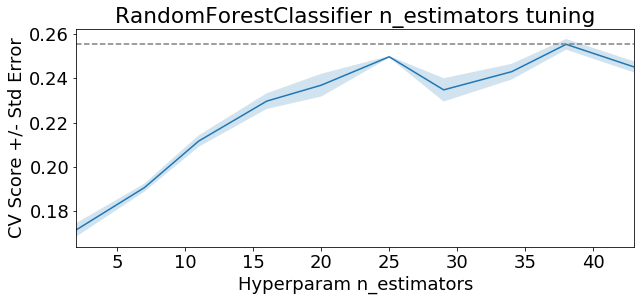

Highest score is 0.2646633591977038 Hyperparam  max_depth : 4
4
Highest score is 0.2579689756584908 Hyperparam  max_depth : 10
10
Highest score is 0.2574544838999747 Hyperparam  max_depth : 13
13
Highest score is 0.2589674958072931 Hyperparam  max_depth : 18
18
Highest score is 0.2579815714440638 Hyperparam  max_depth : 7
7


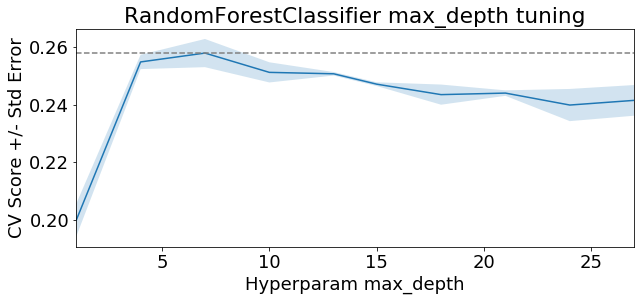

Highest score is 0.2723732026812434 Hyperparam  min_samples_split : 8
8
Highest score is 0.27803157978493154 Hyperparam  min_samples_split : 6
6


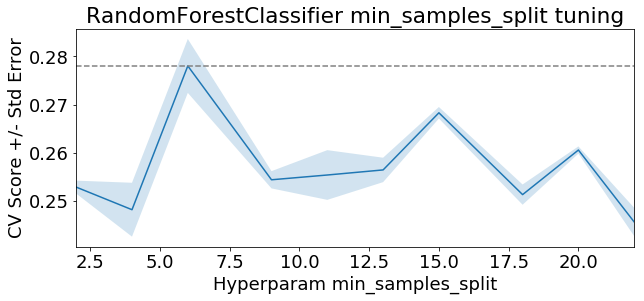

Highest score is 0.2682603100345094 Hyperparam  min_samples_leaf : 11
11
Highest score is 0.26569776811896073 Hyperparam  min_samples_leaf : 22
22
Highest score is 0.2646355317280158 Hyperparam  min_samples_leaf : 7
7


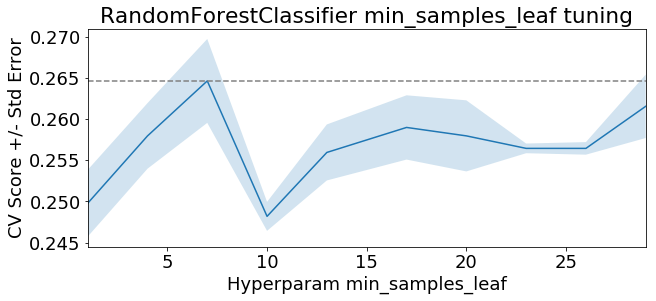

Score of : 0.24897119341563786
                     precision    recall  f1-score   support

African_hunting_dog       0.29      0.52      0.38        42
          Chihuahua       0.17      0.05      0.08        38
         Eskimo_dog       0.06      0.03      0.04        38
        Maltese_dog       0.31      0.57      0.40        63
       Newfoundland       0.26      0.49      0.34        49
            Samoyed       0.23      0.24      0.23        55
     Siberian_husky       0.23      0.35      0.28        48
     cocker_spaniel       0.16      0.07      0.10        40
    giant_schnauzer       0.21      0.08      0.11        39
   golden_retriever       0.00      0.00      0.00        37
            redbone       0.00      0.00      0.00        37

          micro avg       0.25      0.25      0.25       486
          macro avg       0.17      0.22      0.18       486
       weighted avg       0.19      0.25      0.20       486



In [15]:
rf = RandomForestClassifier()
rf.n_estimators = hyper_param(rf, X, y, 'n_estimators')
rf.max_depth = hyper_param(rf, X, y, 'max_depth')
rf.min_samples_split = hyper_param(rf, X, y, 'min_samples_split')
rf.min_samples_leaf = hyper_param(rf, X, y, 'min_samples_leaf')


silent = rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print('Score of :',rf.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Confusion matrix, without normalization
[[24  3  5  0  3  1  0  1  3  2  2  5]
 [22  3  3  0  3  1  0  0  1  0  0  6]
 [ 5  0 36  0  6  0  0  1  3  0  3  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  1  8  0 17  5  0  1  7  2  0  3]
 [ 4  1  7  0 15  1  0  1  5  0  2  2]
 [ 6  1  8  0  9  0  0  2  6  0  1  4]
 [ 1  2  6  0  8  2  0  2 12  0  2  3]
 [ 5  0  3  0  5  4  0  1 22  1  1  0]
 [ 2  0 12  0  3  1  0  1  8  0  2  8]
 [10  3  9  0  3  2  0  2  5  0  3  3]
 [10  0 21  0  2  1  1  0  3  1  3 13]]


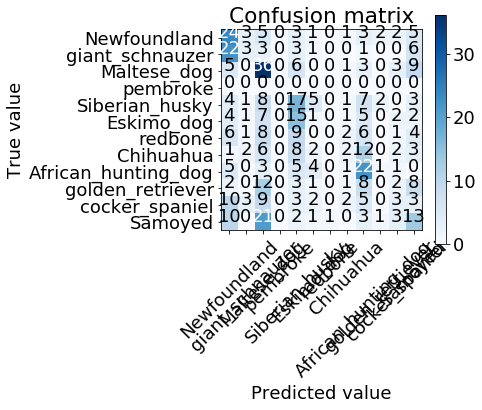

In [16]:
fig_size(7,7)
cm = confusion_matrix(y_test, y_pred, labels =reduced_set)
silent =plot_confusion_matrix(cm, reduced_set)

## Displaying some fails

In [20]:
full_data_df = df
full_data_df.index = full_data_df.id

df_results = pd.DataFrame(np.vstack((y_pred, y_test.values)).T, columns =['predicted', 'true'], index = X_test.index)
labels = df_results['true'].unique()
my_query = '(true == "{0}" and predicted == "{1}") or (true =="{1}" and predicted =="{0}")'.format(labels[0], labels[-1])
df_worst_errors = df_results.query(my_query)
df_worst_errors = df_worst_errors.join(full_data_df).join(X)

giant_schnauzer predicted as Newfoundland


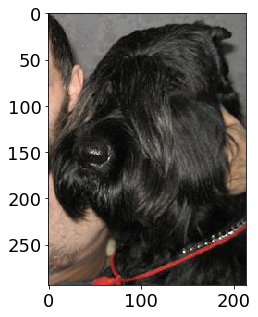

giant_schnauzer predicted as Newfoundland


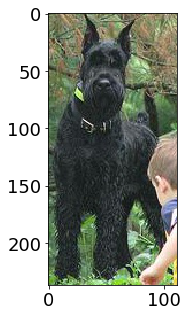

Newfoundland predicted as giant_schnauzer


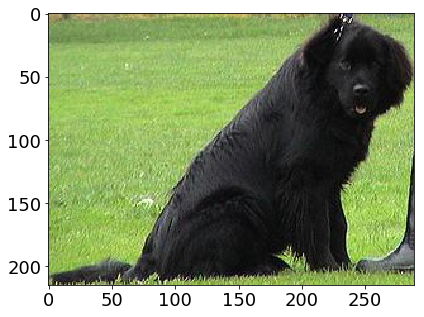

giant_schnauzer predicted as Newfoundland


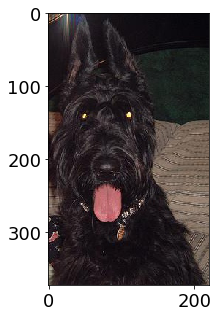

giant_schnauzer predicted as Newfoundland


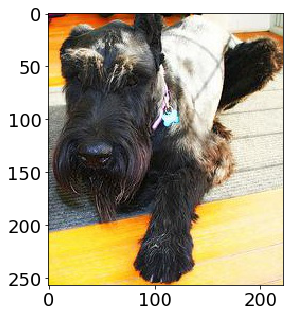

giant_schnauzer predicted as Newfoundland


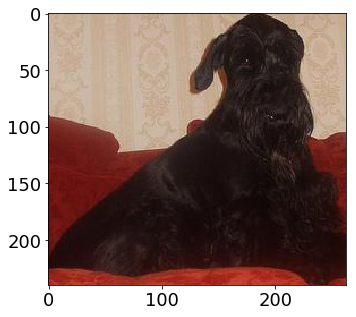

giant_schnauzer predicted as Newfoundland


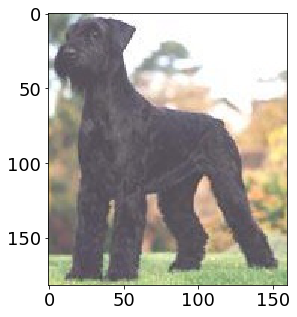

giant_schnauzer predicted as Newfoundland


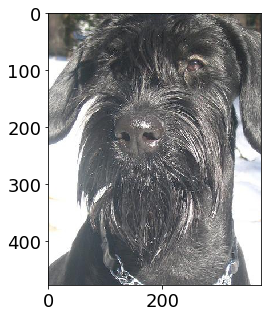

giant_schnauzer predicted as Newfoundland


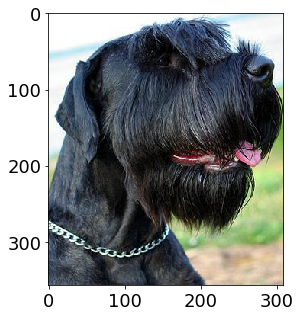

giant_schnauzer predicted as Newfoundland


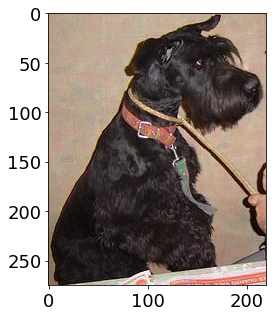

giant_schnauzer predicted as Newfoundland


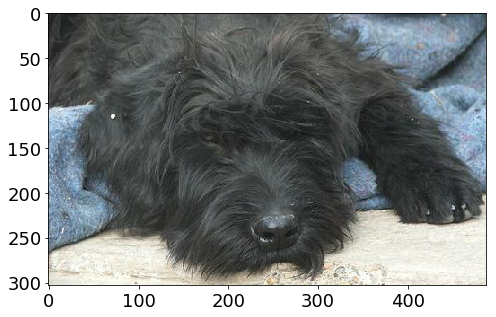

giant_schnauzer predicted as Newfoundland


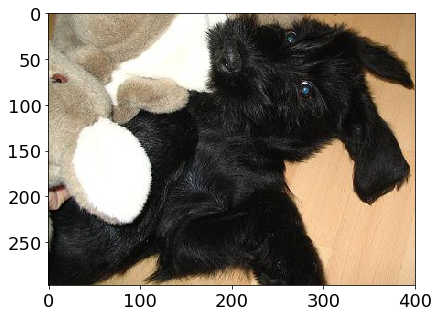

giant_schnauzer predicted as Newfoundland


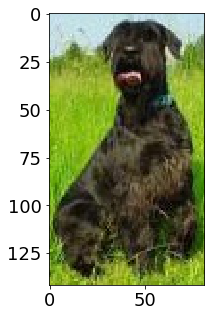

giant_schnauzer predicted as Newfoundland


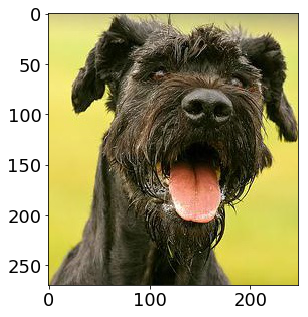

giant_schnauzer predicted as Newfoundland


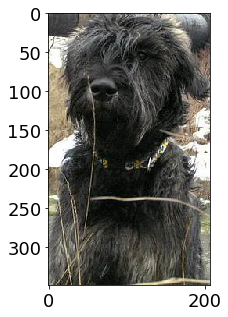

giant_schnauzer predicted as Newfoundland


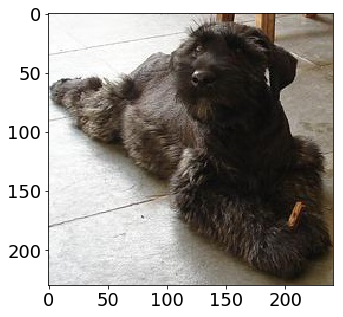

giant_schnauzer predicted as Newfoundland


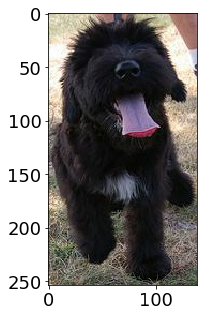

giant_schnauzer predicted as Newfoundland


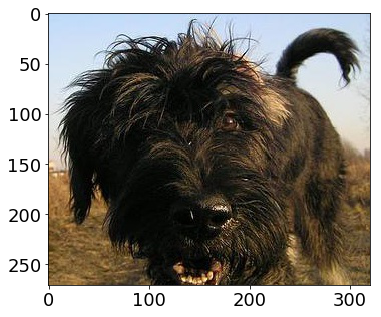

giant_schnauzer predicted as Newfoundland


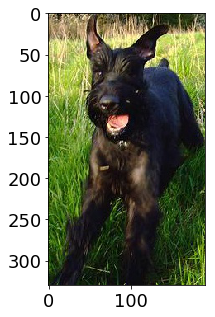

giant_schnauzer predicted as Newfoundland


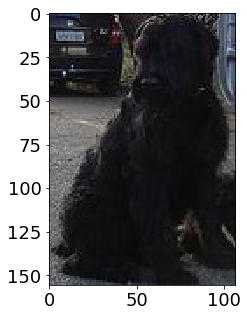

Newfoundland predicted as giant_schnauzer


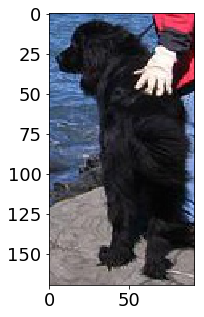

giant_schnauzer predicted as Newfoundland


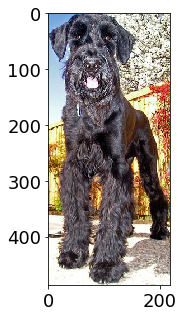

giant_schnauzer predicted as Newfoundland


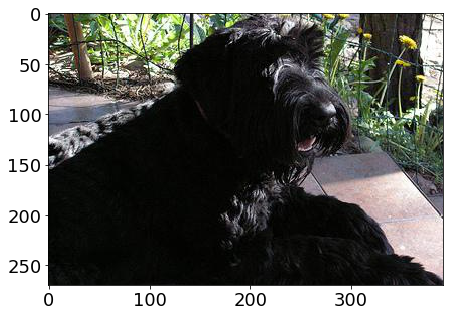

Newfoundland predicted as giant_schnauzer


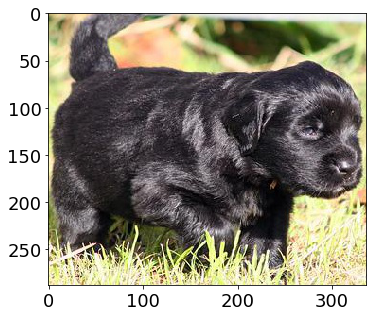

giant_schnauzer predicted as Newfoundland


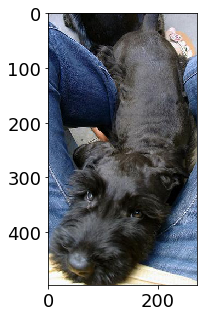

In [21]:
for index, row in df_worst_errors.iterrows() :
    print(row['true'], 'predicted as', row['predicted'])
    img = cv2.imread(row['crop_img'], cv2.IMREAD_UNCHANGED) #IMREAD_UNCHANGED to keep 4th channel with transparency
    imshow(img)
    